In [ ]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In [17]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from quetzal.model import stepmodel
from quetzal.io import excel

# Logit model step
## Needs LoS tables and calibration parameters
## Saves logit probabilities and utilities

In [3]:
input_path = '../input/'
output_path = '../output/' + scenario + '/'
model_path = '../model/'

In [ ]:
# Create a path for output files and plots
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [18]:
# Load parameters for settings
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [ ]:
# Transport demand segments
segments = [s.strip() for s in params['general']['demand_segments'].split(';')]

In [22]:
# Add car sharing, if set in the parameters
car_modes = ['car']
if not np.isnan(params['car_sharing']['asc']):
    car_modes = ['private_car', 'car_sharing']

In [5]:
if scenario.endswith('_equilibrium'):
    sm = stepmodel.read_zippedpickles(model_path + scenario[:-12] + '/' + 'de_pt_los')
else:
    sm = stepmodel.read_zippedpickles(model_path + scenario + '/' + 'de_pt_los')
sm.segments = segments

pt_los: 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:54<00:00, 54.58s/it]


In [6]:
car = stepmodel.read_zippedpickles(model_path + scenario + '/' + 'de_road_los')

car_los: 100%|███████████████████████████████████████████████████████████████████████████| 1/1 [01:14<00:00, 74.40s/it]


In [ ]:
# Load zones
try:
    z = stepmodel.read_json(model_path + scenario + '/' + 'de_zones')
except FileNotFoundError:
    z = stepmodel.read_json(model_path + 'base/' + 'de_zones')

In [7]:
# Scale time to hours
if sm.pt_los['time'].mean() > 3600:
    sm.pt_los['time'] = sm.pt_los['time'] / 3600
elif sm.pt_los['time'].mean() < 10/3600:
    sm.pt_los['time'] = sm.pt_los['time'] * 3600
sm.pt_los['time'].mean()

6.386128012342526

In [8]:
if car.car_los['time'].mean() > 3600:
    car.car_los['time'] = car.car_los['time'] / 3600
car.car_los['time'].mean()

4.239213813569879

In [23]:
# Define route types for the choice tree
route_types = ['rail_long', 'rail_short',
               'bus', 'coach',
               'air', 'walk'] + car_modes

In [10]:
sm.pt_los['route_type'].unique()

array(['bus', 'rail_long', 'rail_short', 'coach', 'air', 'walk'],
      dtype=object)

In [ ]:
# Create a car sharing LoS table, if neccessary
if len(car_modes) > 1:
    to_concat = []
    for c in car_modes:
        los = car.car_los.copy()
        los['route_type'] = c
        los['route_types'] = [(c,) for _ in los.index]
        to_concat.append(los)
    car.car_los = pd.concat(to_concat)

In [12]:
# Create LoS table
sm.los = pd.concat([sm.pt_los, car.car_los])
sm.los.reset_index(drop=True, inplace=True)
len(sm.los)

15309258

In [13]:
# Make route types hashable
sm.los['route_types'] = sm.los['route_types'].apply(tuple)

In [14]:
# Drop columns from previous logit model runs
sm.los.drop([col for col in sm.los.columns if str(col).startswith('(')],
            axis=1, inplace=True, errors='ignore')

In [15]:
# Clean LoS table
sm.los = sm.los.loc[sm.los['time']>0]
sm.los = sm.los.loc[sm.los['length']<=1000000]
len(sm.los)

15257014

## Policies

In [ ]:
# Set the average speed for high-speed rail long-distance travel
# between major cities (population>100,000)
if not np.isnan(params['rail_long']['hsr_speed']):
    urban_zones = z.zones.loc[(z.zones['urbanisation']==1) & (z.zones['population']>=100000), 'FID']
    hsr_mask = (sm.los['origin'].isin(urban_zones)) & (sm.los['destination'].isin(urban_zones)) \
               & (sm.los['route_type']=='rail_long') & (sm.los['route_types'].apply(lambda t: len(t)==1))
    sm.los.loc[hsr_mask, 'time'] = sm.los.loc[hsr_mask, 'length']/1000 / params['rail_long']['hsr_speed']

In [ ]:
# Car-free inner cities
city_pop_share = params['car-free_cities']['population_share_within']
if city_pop_share > 0.1 and city_pop_share <= 1:
    pr_zones = z.zones.loc[z.zones['urbanisation']==1]
    
    # For trips whose destination is a car-free zone
    pr_mask = (sm.los['route_type'].isin(car_modes)) & (sm.los['destination'].isin(pr_zones.index))
    # Add park-and-ride-paths
    pr_paths = sm.los.loc[pr_mask].copy()
    pr_paths['route_types'] = [(t, 'pr') for t in pr_paths['route_type']]
    # Add transfer time and time for local PT based on zone's car-free area
    pr_paths['time'] += params['car-free_cities']['pr_time']
    pr_paths['time'] += np.power(pr_paths['destination'].map(pr_zones['area']), -2) * city_pop_share / 30#km/h
    # Add local PT (parking cost persist)
    for seg in segments:
        pr_paths[seg+'_price'] += params['bus'][1] * params['bus']['multimodal_share']
    sm.los = pd.concat([sm.los, pr_paths]).reset_index(drop=True)
    
    # Inhabitants of car-free zones get the extra time only
    sm.los.loc[(sm.los['route_type'].isin(car_modes))
               & (sm.los['origin'].isin(pr_zones.index)), 'time'
              ] += params['car-free_cities']['pr_time'] * city_pop_share

In [ ]:
# Business trips with PT are covered by the employer
# Car trips depend on the setting on b_c in the scenario's estimation results
sm.los.loc[~sm.los['route_type'].isin(car_modes),
           [s+'_price' for s in segments if 'business' in s]] = 0

## Prepare the logit model

Load parameters and generate LoS columns

In [20]:
# Load estimation results
try:
    excel_file = pd.ExcelFile(input_path + 'estimation_results_{}.xls'.format(scenario))
except FileNotFoundError:
    excel_file = pd.ExcelFile(input_path + 'estimation_results.xls')
params_est = {}
for s in segments: # First two sheets are all purposes
    df = excel_file.parse(s.replace('/', '-'))
    params_est[s] = df.set_index(df.columns[0])

In [29]:
# The nested logit structure can be set for each segment
# It must be the same as in the estimation
segs = segments + ['root']
#col = ['root']*len(route_types) + [np.nan]
#col = ['pt']*(len(route_types)-3) + ['root']*4 + [np.nan]
col = ['rail']*2 + ['root']*(len(route_types)-2) + ['root'] + [np.nan]
ind = route_types + ['rail', 'root']
if len(car_modes) > 1:
    col = ['rail']*2 + ['root']*(len(route_types)-2-2) + ['car']*len(car_modes) + ['root']*2 + [np.nan]
    ind = route_types + ['rail', 'car', 'root']
nests = pd.DataFrame(index=ind, data={s: col for s in segments})
nests.index.name = 'route_type'
nests.columns.name = 'segment'
sm.mode_nests = nests
sm.mode_nests

segment,commuting_no_car,commuting_car,business_no_car,business_car,education_no_car,education_car,buy/execute_no_car,buy/execute_car,leisure_no_car,leisure_car,accompany_no_car,accompany_car
route_type,,,,,,,,,,,,
rail_long,rail,rail,rail,rail,rail,rail,rail,rail,rail,rail,rail,rail
rail_short,rail,rail,rail,rail,rail,rail,rail,rail,rail,rail,rail,rail
bus,root,root,root,root,root,root,root,root,root,root,root,root
coach,root,root,root,root,root,root,root,root,root,root,root,root
air,root,root,root,root,root,root,root,root,root,root,root,root
walk,root,root,root,root,root,root,root,root,root,root,root,root
private_car,car,car,car,car,car,car,car,car,car,car,car,car
car_sharing,car,car,car,car,car,car,car,car,car,car,car,car
rail,root,root,root,root,root,root,root,root,root,root,root,root


In [30]:
# phi/theta values for each mode and nest come from calibration data
sm.logit_scales = pd.DataFrame(index=route_types, data={seg: 1 for seg in segments})
sm.logit_scales.loc['root'] = [1 for i in range(len(segments))]
# For the nested structure
sm.logit_scales.loc['rail'] = [1 / params_est[s].loc['mu_rail', 'Value'] for s in segments]
if len(car_modes) > 1:
    sm.logit_scales.loc['car'] = [params['car_sharing']['phi'] for s in segments]
sm.logit_scales

,commuting_no_car,commuting_car,business_no_car,business_car,education_no_car,education_car,buy/execute_no_car,buy/execute_car,leisure_no_car,leisure_car,accompany_no_car,accompany_car
rail_long,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.0
rail_short,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.0
bus,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.0
coach,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.0
air,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.0
walk,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.0
private_car,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.0
car_sharing,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.0
root,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.0
rail,0.171177,1.0,0.1,1.0,0.222706,0.592969,0.157832,1.0,0.178314,1.0,1.0,1.0


In [32]:
# Initial values are the alternative specific constants (ASC) from calibration
sm.mode_utility = pd.DataFrame({seg: [] for seg in segments})
for t, asc in [#('rail', 'asc_rail'),
               ('rail_short', 'asc_rail_s'),
               ('rail_long', 'asc_rail_l'),
               ('coach', 'asc_coach'),
               ('bus', 'asc_bus'),
               ('air', 'asc_air'),
               ('walk', 'asc_non_motor')]:
    sm.mode_utility.loc[t] = [params_est[s].loc[asc, 'Value'] for s in segments]
for c in car_modes:
    sm.mode_utility.loc[c] = 0 if c!='car_sharing' else params['car_sharing']['asc']
sm.mode_utility.loc['root'] = 0
# Make cars unavailable in households without cars
for seg in [s for s in segments if '_no_car' in s]:
    sm.mode_utility.loc[car_modes[0], seg] = -50
# Make car sharing unavailable in households with cars
if len(car_modes) > 1:
    for seg in [s for s in segments if not '_no_' in s]:
        sm.mode_utility.loc[car_modes[1], seg] = -50
# Correct rail with disutility from perceived delay
#sm.mode_utility.loc['rail_short', [s for s in segments if not 'business' in s]
#                   ] -= params['rail_short']['delay_disutility']
sm.mode_utility

,commuting_no_car,commuting_car,business_no_car,business_car,education_no_car,education_car,buy/execute_no_car,buy/execute_car,leisure_no_car,leisure_car,accompany_no_car,accompany_car
rail_short,2.359079,-2.138598,1.301126,-3.546011,2.352240,-0.453749,1.743929,-3.310471,2.109426,-2.929028,4.727849,-4.477453
rail_long,2.174942,-0.209608,1.131816,-2.535069,2.008072,-0.936989,1.493238,-2.559774,1.852291,-2.793347,1.669151,-5.463545
coach,1.714616,-6.400727,-0.024322,-3.603262,2.437864,0.083417,1.690762,-4.769319,1.424182,-2.474668,1.587915,-4.771774
bus,2.056730,-2.760873,0.382565,-3.651776,2.884864,0.252604,1.592767,-3.749123,1.971179,-3.277372,2.911967,-4.597081
air,-7.045840,-5.267668,-2.485519,-2.292413,-7.358431,-5.405515,-6.130316,-1.855169,-7.110127,-1.471736,-2.540529,-6.010799
walk,-1.259527,-6.227041,-0.305666,-5.547045,-2.324610,-2.695877,-0.390379,-4.646630,-0.246951,-3.542913,-8.356354,-5.408456
private_car,-50.000000,0.000000,-50.000000,0.000000,-50.000000,0.000000,-50.000000,0.000000,-50.000000,0.000000,-50.000000,0.000000
car_sharing,0.000000,-50.000000,0.000000,-50.000000,0.000000,-50.000000,0.000000,-50.000000,0.000000,-50.000000,0.000000,-50.000000
root,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [21]:
# Performance attributes for mode choice
perf_attrs = [s+'_time' for s in segments] + [s+'_price' for s in segments]

In [22]:
# Beta parameters from calibration data
# IMPORTANT: mind the unit conversion
sm.utility_values = pd.DataFrame({s: [0 for _ in perf_attrs] for s in segments},
                                 index=[str(a) for a in perf_attrs])
#sm.utility_values.loc['waiting_time'] = [params_est[seg].loc['b_wt', 'Value'] for seg in segments]
sm.utility_values.loc['mode_utility'] = [1 for seg in segments]
for s in segments:
    sm.utility_values.loc[s+'_time', s] = params_est[s].loc['b_t', 'Value']
    try:
        sm.utility_values.loc[s+'_price', s] = params_est[s].loc['b_c', 'Value']
    except KeyError: # Business has no b_c
        sm.utility_values.loc[s+'_price', s] = 0
sm.utility_values

,commuting_no_car,commuting_car,business_no_car,business_car,education_no_car,education_car,buy/execute_no_car,buy/execute_car,leisure_no_car,leisure_car,accompany_no_car,accompany_car
commuting_no_car_time,-0.015532,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
commuting_car_time,0.000000,-0.019029,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
business_no_car_time,0.000000,0.000000,-0.023167,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
business_car_time,0.000000,0.000000,0.000000,-0.015715,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
education_no_car_time,0.000000,0.000000,0.000000,0.000000,-0.100950,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
education_car_time,0.000000,0.000000,0.000000,0.000000,0.000000,-0.078346,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
buy/execute_no_car_time,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.069736,0.000000,0.000000,0.000000,0.000000,0.000000
buy/execute_car_time,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.023120,0.000000,0.000000,0.000000,0.000000
leisure_no_car_time,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.026703,0.000000,0.000000,0.000000
leisure_car_time,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.022195,0.000000,0.000000


In [23]:
# Generate damped cost (see cal20)
c = params['estimation'].to_dict()
def spline(x, beta, c1, c2, Q=3):
    alpha = [0, -beta/2*np.power(np.log(c1),3),
             -beta/2*np.log(c1)*(3*np.power(np.log(c2),2)+np.power(np.log(c1),2))] # for Q=3
    theta = [1, 3/2*np.log(c1), 3*np.log(c1)*np.log(c2)] # for Q=3
    return (beta*theta[0]*np.power(np.log(x),Q-1+1) + alpha[0]) * (x<c1) \
    + (beta*theta[1]*np.power(np.log(x),Q-2+1) + alpha[1]) * (x>=c1)*(x<c2) \
    + (beta*theta[2]*np.power(np.log(x),Q-3+1) + alpha[2]) * (x>=c2)

In [24]:
# Apply the spline function
for s in tqdm(segments):
    c1 = c['c1_time_'+s]
    c2 = c['c2_time_'+s]
    beta = sm.utility_values.loc[s+'_time', s]
    sm.los[s+'_time'] = spline(sm.los['time']*60, beta, c1*60, c2*60)

100%|███████████████████████████████████████████████████████████████████████████████| 12/12 [2:33:52<00:00, 769.38s/it]


In [25]:
# Make beta_t one because it is now included in the LoS attribute 't'
for s in segments:
    sm.utility_values.loc[s+'_time', s] = 1

In [ ]:
# Divide price by income change (i.e. price sensitivity)
for s in segments:
    sm.los[s + '_price'] /= sm.los['origin'].map(z.zones['urbanisation']).map(
        params['income_change'])

## Mode Choice

In [60]:
# Build the utility column in sm.los for each segment
# How defines the mode which ASC is taken: "min" is worst mode in route_types,
# "max" is best, "sum" and "mean"
# Set the main mode as route types to take only this ASC
#sm.los['route_types'] = [(i,) for i in sm.los['route_type']]
sm.analysis_mode_utility(how='main', segment=None)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [02:07<00:00, 10.67s/it]


In [61]:
# Run the logit model to calculate probabilities
sm.step_logit()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:10<00:00, 13.03s/it]


In [63]:
sm.probabilities.head(3)

route_type,origin,destination,segment,root,walk,car,air,coach,bus,rail,rail_short,rail_long
25589031,DEA43_6,DEA34_1,education_car,1,0.0,0.583195,0.0,0.190024,0.000000,0.226781,0.226781,0.000000
3794625,DEA28_0,DEA27_1,commuting_no_car,1,0.0,0.077039,0.0,0.000000,0.259019,0.663942,0.663942,0.000000
35049590,DEE05_4,DE21A_3,buy/execute_car,1,0.0,0.911417,0.0,0.000000,0.000000,0.088583,0.000000,0.088583


In [64]:
sm.utilities.head(3)

route_type,origin,destination,segment,root,walk,car,air,coach,bus,rail,rail_short,rail_long
26526807,DEA2D_3,DEA1D_4,education_car,-1.610491,-inf,-2.519406,-inf,-3.403745,-3.795437,-2.755764,-2.851772,-3.882743
40439582,DEB14_2,DEC04_1,leisure_no_car,0.280695,-inf,-2.189530,-inf,-inf,-inf,0.192338,0.192338,-inf
16061072,DE723_2,DED42_7,business_car,-2.485910,-inf,-2.539543,-inf,-7.075525,-inf,-5.654502,-inf,-5.654502


In [ ]:
# Set the probability for choosing P&R into a car-free city
# emulate a P&R model with the probability given as population share
if city_pop_share > 0.1 and city_pop_share <= 1:
    sm.los.columns = [str(c) for c in sm.los.columns]
    pr_mask = (sm.los['route_type'].isin(car_modes)) & (sm.los['destination'].isin(pr_zones.index))
    prob_sum = sm.los.loc[pr_mask].groupby(['origin', 'destination']).agg(
        {str((seg, 'probability')): 'sum' for seg in segments})
    is_pr = pr_mask & (sm.los['route_types'].apply(lambda t: 'pr' in t))
    not_pr = pr_mask & ~(sm.los['route_types'].apply(lambda t: 'pr' in t))
    for seg in segments:
        sm.los.loc[is_pr, str((seg, 'probability'))] = pd.merge(
            sm.los.loc[is_pr, ['origin', 'destination']], prob_sum[str((seg, 'probability'))],
            how='left', left_on=['origin', 'destination'], right_index=True
        )[str((seg, 'probability'))] * city_pop_share
        sm.los.loc[not_pr, str((seg, 'probability'))] = pd.merge(
            sm.los.loc[not_pr, ['origin', 'destination']], prob_sum[str((seg, 'probability'))],
            how='left', left_on=['origin', 'destination'], right_index=True
        )[str((seg, 'probability'))] * (1 - city_pop_share)
    sm.los.rename(columns={c: eval(c) for c in sm.los.columns if ',' in c}, inplace=True)

In [66]:
# Validate that probabilities sum up to one
od = sm.los.groupby(['origin', 'destination']).sum()[
    [(seg, 'probability') for seg in sm.segments]].mean(axis=1)
print(od.mean())
print(od.max())
print(od.min())

1.0
1.0000000000000002
0.9999999999999999


## Save model

In [36]:
sm.utilities.reset_index(drop=True, inplace=True)
sm.probabilities.reset_index(drop=True, inplace=True)
sm.to_zippedpickles(model_path + scenario + '/' + 'de_logit', only_attributes=[
    'segments', 'mode_nests', 'logit_scales', 'mode_utility',
    'utility_values', 'probabilities', 'utilities'])

volumes: 100%|█████████████████████████████████████████████████████████████████████████| 15/15 [04:47<00:00, 19.16s/it]


In [37]:
# Save LoS table
if 'route_type_network' in sm.los.columns:
    sm.los['route_type'] = sm.los['route_type_network']
sm.pt_los = sm.los.loc[~sm.los['route_type'].isin(car_modes)].reset_index(drop=True)
sm.to_zippedpickles(model_path + scenario + '/' + 'de_pt_los', only_attributes=['pt_los'])
sm.car_los = sm.los.loc[sm.los['route_type'].isin(car_modes)].reset_index(drop=True)
sm.to_zippedpickles(model_path + scenario + '/' + 'de_road_los', only_attributes=['car_los'])

car_los: 100%|█████████████████████████████████████████████████████████████████████████| 16/16 [04:37<00:00, 17.36s/it]


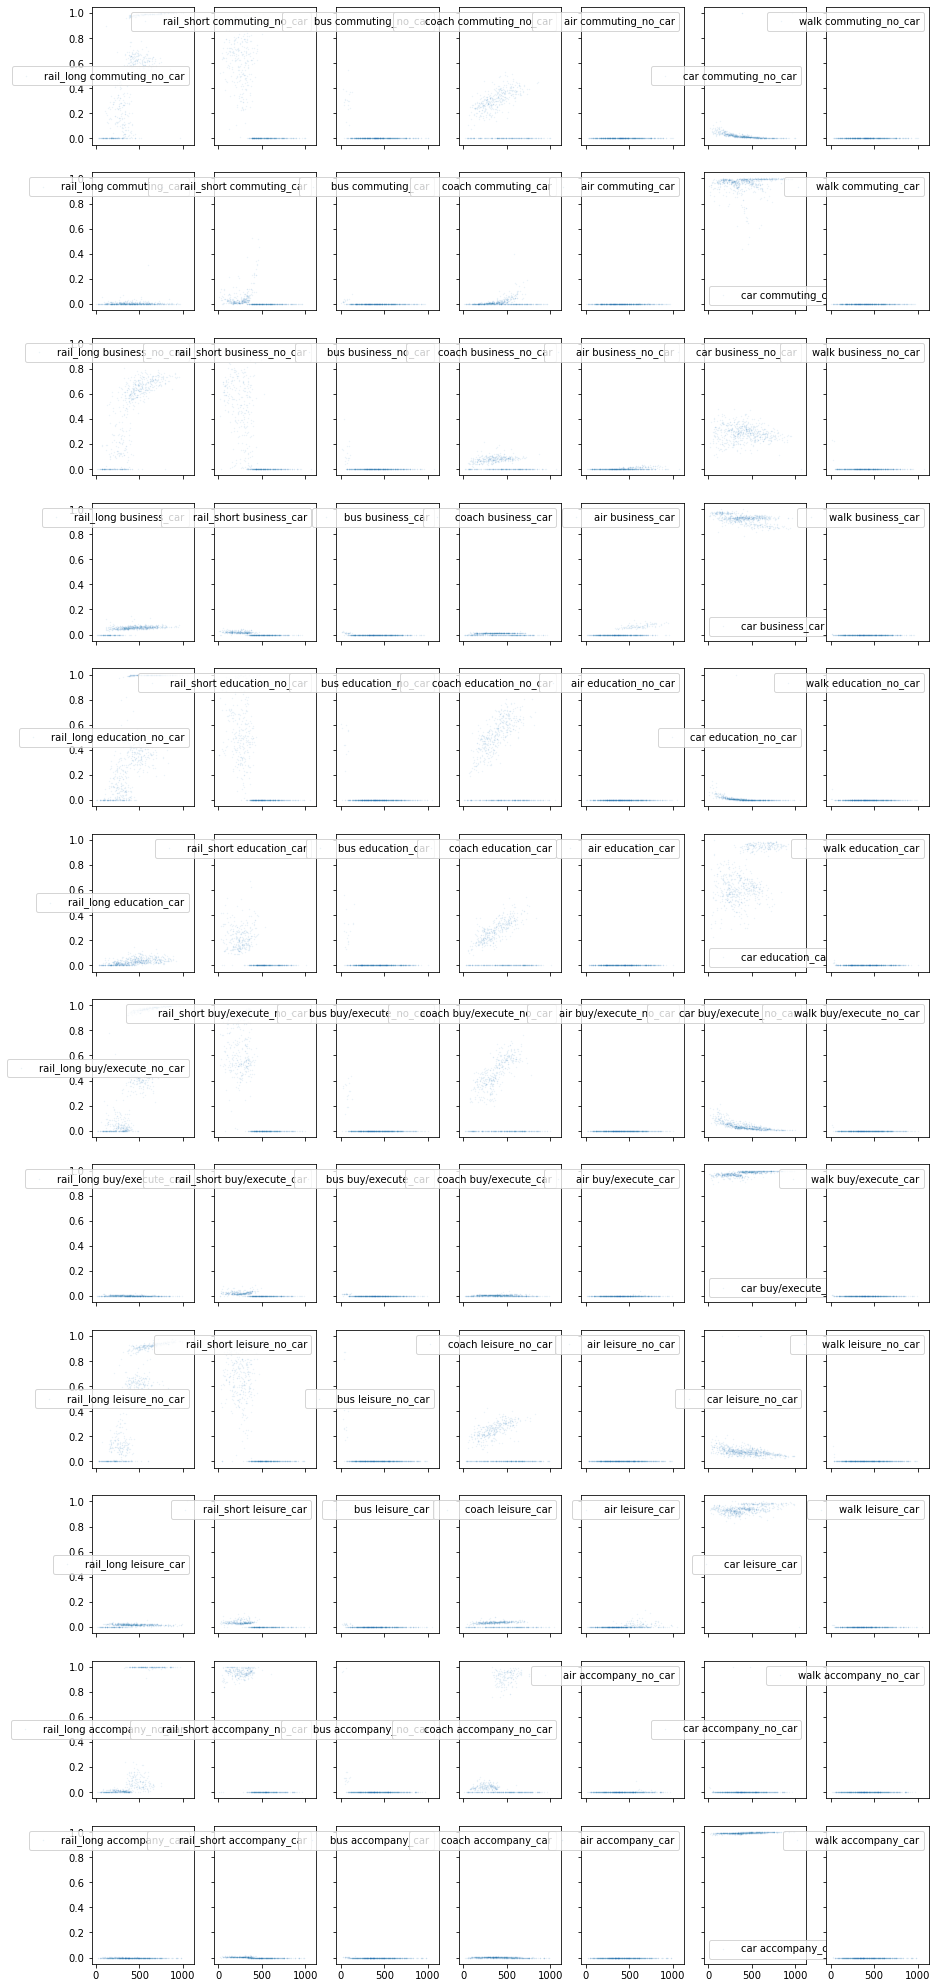

In [38]:
# Distance-distribution of probabilities
if manual:
    merged = sm.probabilities.sample(max(int(len(sm.probabilities)**0.5), 100000)).merge(
        car.car_los[['origin', 'destination', 'length']],
        on=['origin', 'destination'],
        how='inner')
    fig, ax = plt.subplots(nrows=len(segments), ncols=len(route_types),
                           sharex='all', sharey='all', figsize=(15,len(segments)*3))
    for j, mode in zip(range(len(route_types)), route_types):
        for i, seg in zip(range(len(segments)), segments):
            x = merged.loc[merged['segment']==seg, 'length'] / 1000
            y = merged.loc[merged['segment']==seg, mode]
            ax[i,j].scatter(x, y, marker='o', s=.15, alpha=.1, label=mode+' '+seg)
            #p = np.poly1d(np.polyfit(x, y, deg=3))
            #ax[i,j].plot(x, p(x), linestyle='', marker='o', markersize=.5, color='grey', label=mode+' '+seg)
            ax[i,j].legend()

### Save composite generalised cost / logsum
For sequential destination choice modelling

In [39]:
# define the logsum function with numpy
def logsum(v_list):
    # Given a list of pre-calculated negative utilities
    return np.log(np.sum([np.exp(-1 * v) for v in v_list]))

In [ ]:
# Apply income change again
for s in segments:
    sm.los[s + '_price'] /= sm.los['origin'].map(z.zones['urbanisation']).map(
        params['income_change'])

In [40]:
# Calculate the logsum of cost parameters
if True:#manual:
    # Make price utility negative by multiplying with betas (time already is)
    for s in segments:
        try:
            sm.los[s + '_price'] *= params_est[s].loc['b_c', 'Value']
        except KeyError: # business does not have beta for prices
            sm.los[s + '_price'] = 0
    # Calculate composite cost for price and time
    comp_cost = sm.los.groupby(['origin', 'destination']).agg(
        {col: logsum for col in perf_attrs})
    # Sum up generalised cost
    for s in segments:
        attrs = [s+'_time', s+'_price']
        comp_cost[s] = comp_cost[attrs].sum(axis=1)
        comp_cost.drop(attrs, axis=1, inplace=True)
    # Save
    comp_cost.to_csv(output_path + 'mode_choice_od_composite_cost.csv')

In [41]:
# Calculate the logsum for utility
#comp_u = sm.los.groupby(['origin', 'destination']).agg(
#    {(s, 'utility'): logsum for s in segments})
# Save it
#comp_u.columns = [c.split("'")[1] for c in comp_u.columns]
#comp_u.to_csv(output_path + 'mode_choice_od_composite_utility.csv')

In [ ]:
# Reset income change
for s in segments:
    sm.los[s + '_price'] *= sm.los['origin'].map(z.zones['urbanisation']).map(
        params['income_change'])